In [1]:
import numpy as np
import pandas as pd
import fynance as fy
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import torch
from torch import nn

# plt.style.use("seaborn")

# Tests Neural Network prediction on fictive financial time series

The aim of this notebook is to evaluate the capicity to learn of different deep learning models (MLP, GRU, LSTM). We use fictive data, build like AutoRegressive model with time-dependent parameters.

## I - Setup Data and model parameters

### I.A - Create periodical time series

Build an autoregressive time series $Y$ such that $\forall t \in [1, T] Y_t = a^t_1 * Y_{t - 1} + ... + a^t_n * Y_{t - n} + c + \epsilon$

$\forall$ $i$ $\in$ $[1, n]$ $a_i(t) = \alpha_i * cos(t)$
such that $\alpha_i \in [-\frac{1}{\sqrt{n}}, \frac{1}{\sqrt{n}}]$

We note the matrix $A = \begin{bmatrix} a^1_1 & ... & a^1_n \\ \vdots & \ddots & \vdots \\ a^t_1 & ... & a^t_n \end{bmatrix}$

<!-- and the matrix $X = \begin{bmatrix} Y_{0} & ... & Y_{-(n - 1)} \\ \vdots & \ddots & \vdots \\ Y_{T - 1} & ... & Y_{T - n} \end{bmatrix}$ -->

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8728 [00:00<?, ?it/s]

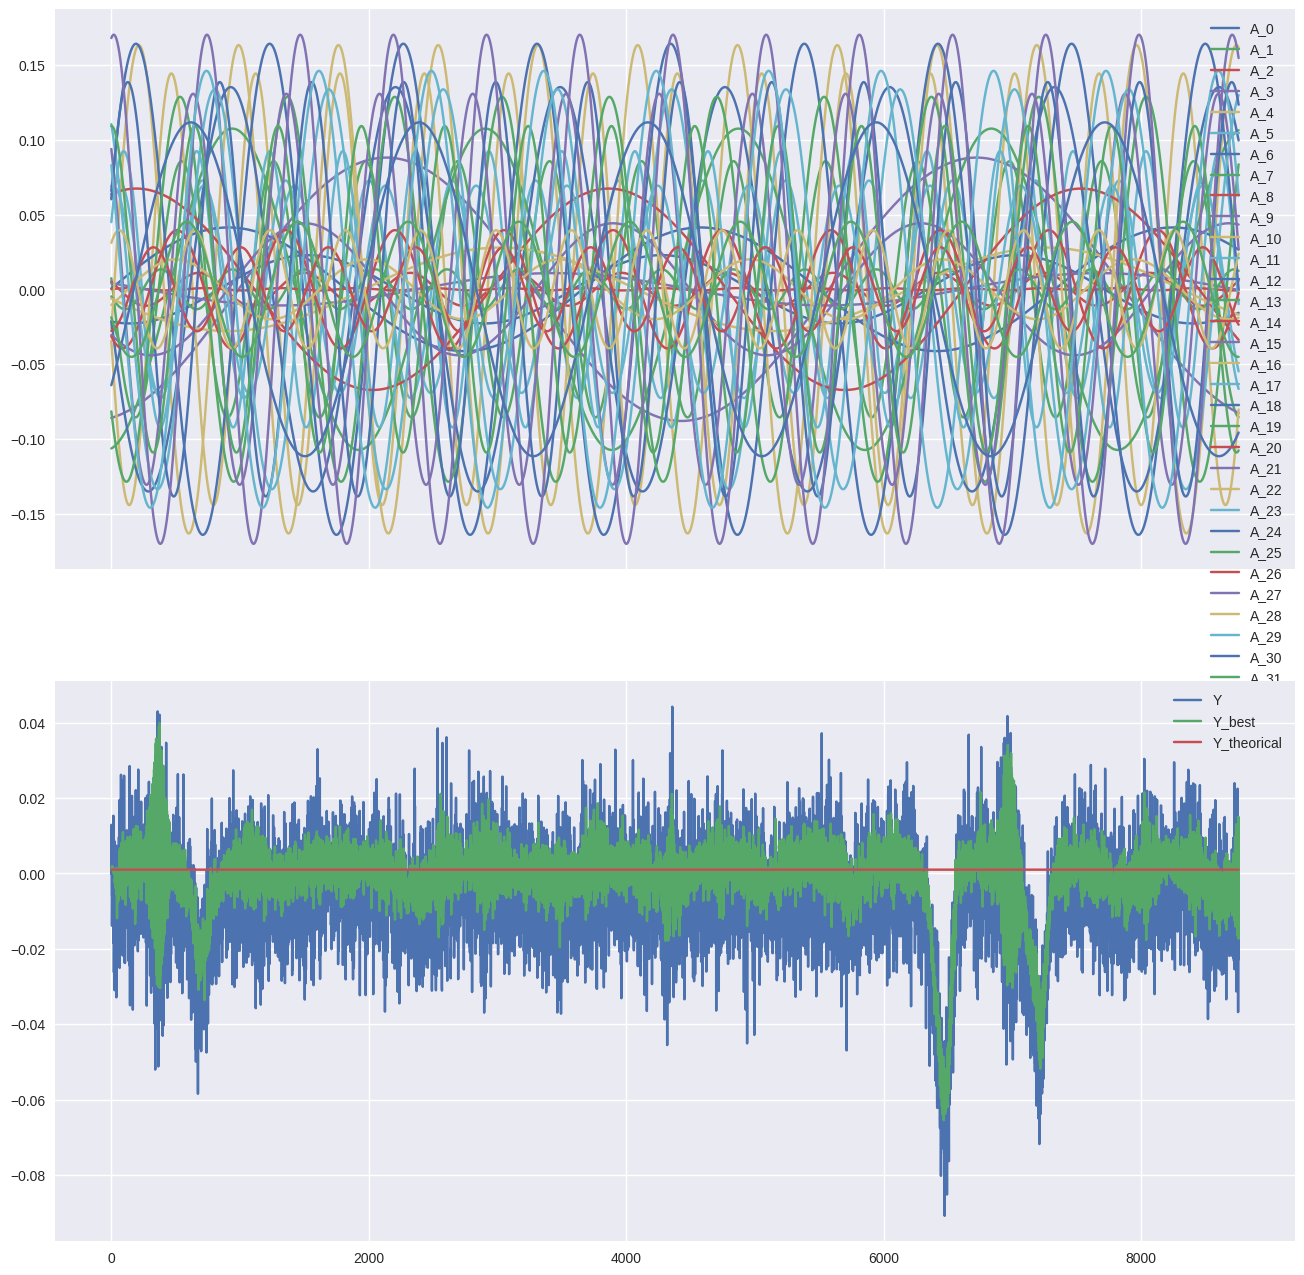

In [3]:
# Set time axis
T = 365 * 24 #* 60 # = 365d * 24H * 60M
t_idx = torch.arange(T)

n_lag = 32
Y_raw = torch.zeros([T, 1], dtype=torch.float32)
Y_the = torch.zeros([T, 1], dtype=torch.float32)
Y_bes = torch.zeros([T, 1], dtype=torch.float32)
epsi = torch.randn(t_idx.shape) * 0.01 - 0.005# - 0.1
# epsi = torch.zeros(t_idx.shape)

# Set matrix A 
A = torch.zeros([T, n_lag])
freq_min, freq_max = 10, 100

alpha = 1 / n_lag ** .5

# Compute each series of A
for i in range(n_lag):
    # Get frequency coef
    freq = np.random.randint(freq_min, freq_max) / T

    # Get magnitude coef
    coef = 2 * alpha * np.random.rand() - alpha + np.random.rand() * 0.0

    # Compute series a_i
    A[:, i] = coef * np.cos(t_idx * freq + np.random.rand() * 2 * np.pi) # + np.random.rand() * 0.001

cst = 0.000 # 0.0001

# Set Y as auto regressive model
# For t in [0, n_lag]
for t in tqdm(range(n_lag)):
    for i in range(t):
        Y_raw[t, 0] = A[t, :i + 1] @ Y_raw[:i + 1, 0]
        Y_the[t, 0] = A[t, :i + 1] @ Y_the[:i + 1, 0]
        Y_bes[t, 0] = A[t, :i + 1] @ Y_raw[:i + 1, 0]

    Y_raw[t] += cst + epsi[t]
    Y_the[t] += cst
    Y_bes[t] += cst

# For t in [n_lag, T]
for t in tqdm(range(n_lag, T)):
    Y_raw[t] = A[t, :] @ Y_raw[t - n_lag: t, 0] + cst + epsi[t]
    Y_the[t] = A[t, :] @ Y_the[t - n_lag: t, 0] + cst
    Y_bes[t] = A[t, :] @ Y_raw[t - n_lag: t, 0] + cst

# Add a trend
Y_raw += 0.001
Y_the += 0.001
Y_bes += 0.001

# Plot the target
f, ax = plt.subplots(2, 1, figsize=(16, 16), sharex=True)

for i in range(n_lag):
    ax[0].plot(A[:, i], label=f"A_{i}")

ax[0].legend(loc="upper right")

ax[1].plot(Y_raw, label="Y")
ax[1].plot(Y_bes, label="Y_best")
ax[1].plot(Y_the, label="Y_theorical")
ax[1].legend()

plt.show()

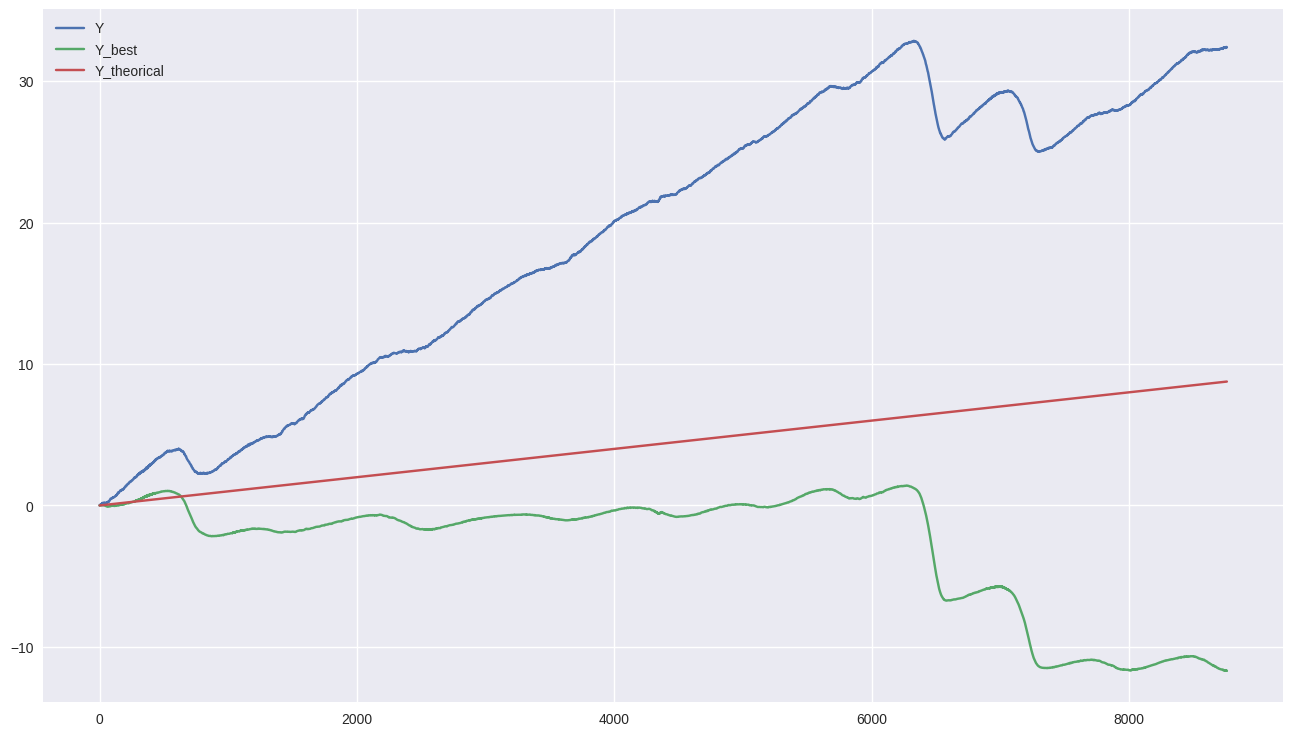

In [4]:
f, ax = plt.subplots(1, 1, figsize=(16, 9))

ax.plot((Y_raw + 0.01).cumsum(0), label="Y")
ax.plot(Y_bes.cumsum(0), label="Y_best")
ax.plot(Y_the.cumsum(0), label="Y_theorical")
ax.legend()

plt.show()

In [5]:
print(f"min: {Y_raw.min():.2f} | max: {Y_raw.max():.2f} | mean: {Y_raw.mean():.2} | std: {Y_raw.std():.2}")

min: -0.09 | max: 0.04 | mean: -0.0063 | std: 0.014


### I.B - Rescale data

In [6]:
scale_y = fy.Scale(Y_raw.numpy(), kind="std")

Y = scale_y(Y_raw)

In [7]:
print(f"min: {Y.min():.2f} | max: {Y.max():.2f} | mean: {Y.mean():.2} | std: {Y.std():.2}")

min: -5.99 | max: 3.58 | mean: -8.1e-09 | std: 1.0


### I.C - Set input data

In [8]:
# Set X

X = torch.zeros([T, n_lag], dtype=torch.float32)

for i in tqdm(range(1, n_lag + 1)):
    X[i:, i - 1] = Y[:-i, 0]

X

  0%|          | 0/32 [00:00<?, ?it/s]

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.4406,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 1.3603,  0.4406,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.4194, -2.1607,  0.7885,  ...,  2.1439,  0.8175, -1.3504],
        [ 1.1833, -0.4194, -2.1607,  ..., -0.9737,  2.1439,  0.8175],
        [-1.1688,  1.1833, -0.4194,  ...,  0.5293, -0.9737,  2.1439]])

In [9]:
# Extra data
extra_data = False

if extra_data:
    # X = torch.cat([X, a.reshape([T, 1]), b.reshape([T, 1]), (a * b).reshape([T, 1])], dim=1)
    X = torch.cat([X, A], dim=1)

X

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.4406,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 1.3603,  0.4406,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.4194, -2.1607,  0.7885,  ...,  2.1439,  0.8175, -1.3504],
        [ 1.1833, -0.4194, -2.1607,  ..., -0.9737,  2.1439,  0.8175],
        [-1.1688,  1.1833, -0.4194,  ...,  0.5293, -0.9737,  2.1439]])

### I.D - Recast input data for RNN

In [11]:
# n = 8 * 60
# m = int(T / n)
m = 365 * 24
n = int(T / m)

print(T / n)

Yt = Y.reshape([n, m, 1])
Xt = torch.zeros([n, m, n_lag])

# Set X
for i in range(1, n_lag + 1):
    Xt[:, i:, i - 1] = Yt[:, :-i, 0]

Xt

8760.0


tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.4406,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 1.3603,  0.4406,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [-0.4194, -2.1607,  0.7885,  ...,  2.1439,  0.8175, -1.3504],
         [ 1.1833, -0.4194, -2.1607,  ..., -0.9737,  2.1439,  0.8175],
         [-1.1688,  1.1833, -0.4194,  ...,  0.5293, -0.9737,  2.1439]]])

In [ ]:
# Add extra data

if extra_data:
    for i in range(n_lag):
        Xt = torch.cat([Xt, A[:, i].reshape(n, m, 1)], dim=2)

Xt

### I.E - Set model parameters, eval function and some benchmarks

In [32]:
feed_forward_activation = lambda: lambda x: x
# feed_forward_activation = nn.Sigmoid
# feed_forward_activation = nn.Tanh

criterion = torch.nn.MSELoss
optimizer = torch.optim.Adamax


In [33]:
T_train = int(T * 2 / 3)

def mse(y, x):
    return ((y - x) ** 2).mean()

def mae(y, x):
    return (y - x).abs().mean()

def OLS(Y, X):
    return X @ (torch.linalg.inv(X.T @ X) @ X.T @ Y)

def unscale(x):
    return torch.from_numpy(scale_y.revert(x.numpy()))

def scores(y, x):
    return mse(y, x), mse(unscale(y), unscale(x)), mae(x, y), mae(unscale(y), unscale(x))

_tmp_y = Y[T_train:, 0]

bench = {
    'lag1': scores(X[T_train:, 0], _tmp_y),
    'mean': scores(_tmp_y.mean(), _tmp_y),
    'WMA' : scores(torch.from_numpy(fy.wma(X[T_train:, 0].numpy(), w=n_lag)), _tmp_y),
    'OLS' : scores(OLS(Y[T_train:,], X[T_train:,]), Y[T_train:]),
    'theorical' : scores(scale_y(Y_the[T_train:, 0]), _tmp_y),
    'best' : scores(scale_y(Y_bes[T_train:, 0]), _tmp_y),
}

for i, a in enumerate(sorted(bench, key=lambda x: bench.get(x)[0]), 1):
    print(f"{i}th - Benchmark {a:^10} : MSE = {bench[a][0]:8.2e}  &  {bench[a][1]:8.2e}"
          f"  ||  MAE = {bench[a][2]:8.2e}  &  {bench[a][3]:8.2e}")

1th - Benchmark    best    : MSE = 8.13e-01  &  1.25e-04  ||  MAE = 7.22e-01  &  8.97e-03
2th - Benchmark    OLS     : MSE = 8.19e-01  &  1.26e-04  ||  MAE = 7.22e-01  &  8.96e-03
3th - Benchmark    WMA     : MSE = 9.22e-01  &  1.42e-04  ||  MAE = 7.46e-01  &  9.27e-03
4th - Benchmark    mean    : MSE = 1.24e+00  &  1.91e-04  ||  MAE = 8.42e-01  &  1.05e-02
5th - Benchmark theorical  : MSE = 1.58e+00  &  2.44e-04  ||  MAE = 9.47e-01  &  1.18e-02
6th - Benchmark    lag1    : MSE = 1.98e+00  &  3.05e-04  ||  MAE = 1.07e+00  &  1.32e-02


## II - Training and evaluating models

### II.A - Vanilla Neural Network

#### II.A.1 - Multi Layer Perceptron

In [34]:
# Set model
mlp = fy.MultiLayerPerceptron(
    X,
    Y,
    # layers=[64, 64, 64, 64, 64],
    layers=[32, 8],
    activation=feed_forward_activation,
)

# Set optimizer
lr = 0.0001

mlp.set_optimizer(criterion, optimizer, lr=lr)

MultiLayerPerceptron(
  (layers): ModuleList(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)

In [35]:
batch_size = 64
epochs = 20

# Run
for e in tqdm(range(epochs)):
    loss = 0

    # Shuffle index
    rand_idx = np.random.choice(t_idx[:T_train], replace=False, size=T_train)

    # Train
    for t in tqdm(range(0, T_train, batch_size), leave=False):
        s = min(t + batch_size, T_train)
        _slice = rand_idx[t: s]
        loss += mlp.train_on(mlp.X[_slice], mlp.y[_slice])
        tqdm.write(f'Current loss on the training is {loss / ((t / batch_size) + 1):.2e}', end="\r")

    # Predict
    y_hat = mlp.predict(mlp.X[T_train: T])
    score = mse(y_hat, Y[T_train: T])
    unscale_score = mse(unscale(y_hat), unscale(Y[T_train: T]))
    tqdm.write(f"{e + 1}th epochs - Score on the testing set is MSE = {score:.2e}  &  {unscale_score:.2e}")

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5475 [00:00<?, ?it/s]

Score on the testing set is MSE = 9.60e-01  &  1.48e-04


  0%|          | 0/5475 [00:00<?, ?it/s]

Score on the testing set is MSE = 9.55e-01  &  1.47e-04


  0%|          | 0/5475 [00:00<?, ?it/s]

Score on the testing set is MSE = 9.53e-01  &  1.47e-04


  0%|          | 0/5475 [00:00<?, ?it/s]

Score on the testing set is MSE = 9.54e-01  &  1.47e-04


  0%|          | 0/5475 [00:00<?, ?it/s]

Score on the testing set is MSE = 9.58e-01  &  1.48e-04


  0%|          | 0/5475 [00:00<?, ?it/s]

Score on the testing set is MSE = 9.51e-01  &  1.47e-04


  0%|          | 0/5475 [00:00<?, ?it/s]

Score on the testing set is MSE = 9.54e-01  &  1.47e-04


  0%|          | 0/5475 [00:00<?, ?it/s]

Score on the testing set is MSE = 9.54e-01  &  1.47e-04


  0%|          | 0/5475 [00:00<?, ?it/s]

Score on the testing set is MSE = 9.57e-01  &  1.48e-04


  0%|          | 0/5475 [00:00<?, ?it/s]

Score on the testing set is MSE = 9.53e-01  &  1.47e-04


  0%|          | 0/5475 [00:00<?, ?it/s]

Score on the testing set is MSE = 9.49e-01  &  1.46e-04


  0%|          | 0/5475 [00:00<?, ?it/s]

Score on the testing set is MSE = 9.52e-01  &  1.47e-04


  0%|          | 0/5475 [00:00<?, ?it/s]

Score on the testing set is MSE = 9.58e-01  &  1.48e-04


  0%|          | 0/5475 [00:00<?, ?it/s]

Score on the testing set is MSE = 9.54e-01  &  1.47e-04


  0%|          | 0/5475 [00:00<?, ?it/s]

Score on the testing set is MSE = 9.53e-01  &  1.47e-04


  0%|          | 0/5475 [00:00<?, ?it/s]

Score on the testing set is MSE = 9.51e-01  &  1.47e-04


  0%|          | 0/5475 [00:00<?, ?it/s]

Score on the testing set is MSE = 9.58e-01  &  1.48e-04


  0%|          | 0/5475 [00:00<?, ?it/s]

Score on the testing set is MSE = 9.56e-01  &  1.47e-04


  0%|          | 0/5475 [00:00<?, ?it/s]

Score on the testing set is MSE = 9.53e-01  &  1.47e-04


  0%|          | 0/5475 [00:00<?, ?it/s]

Score on the testing set is MSE = 9.56e-01  &  1.47e-04


### II.B - Recurrent Neural Network

#### II.B.1 - Recurrent Neural Network

In [63]:
k = 16

rnn = fy.RecurrentNeuralNetwork(
    Xt.shape[2],
    1,
    # forward_activation=nn.Tanh,
    forward_activation=feed_forward_activation,
    hidden_state_size=k,
)

lr = 0.0001

rnn.set_optimizer(criterion, optimizer, lr=lr)

RecurrentNeuralNetwork(
  (W_h): Linear(in_features=48, out_features=16, bias=True)
  (f_h): Tanh()
  (W_y): Linear(in_features=16, out_features=1, bias=True)
  (criterion): MSELoss()
)

In [64]:
m_train = int(m * 2 / 3)
epochs = 10

Ht = torch.zeros([n, m, k])
Y_hat = torch.zeros(Yt.shape)

# Run
for e in tqdm(range(epochs)):
    loss = 0
    h = torch.zeros([n, rnn.H])

    # Train
    for t in tqdm(range(0, m_train, 1), leave=False):
        s = min(t + 1, m_train)
        _slice = slice(None), t
        l, h = rnn.train_on(Xt[_slice], Yt[_slice], h)
        loss *= t
        loss += l.detach()
        loss /= t + 1
        Ht[_slice] = h
        tqdm.write(f'Current loss on the training is {loss:.2e}', end="\r")

    # Predict
    for t in range(m_train, m, 1):
        s = min(t + 1, m)
        _slice = slice(None), t
        y_hat, h = rnn.predict(Xt[_slice], h)
        Ht[_slice] = h
        Y_hat[_slice] = y_hat

    score = rnn.criterion(Y_hat[:, m_train:, :], Yt[:, m_train:, :]).detach()
    tqdm.write(f"{e + 1}th epochs - Score on the testing set is MSE={score:.2e}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/730 [00:00<?, ?it/s]

Score on the testing set is MSE=9.79e-01


  0%|          | 0/730 [00:00<?, ?it/s]

Score on the testing set is MSE=9.72e-01


  0%|          | 0/730 [00:00<?, ?it/s]

Score on the testing set is MSE=9.71e-01


  0%|          | 0/730 [00:00<?, ?it/s]

Score on the testing set is MSE=9.70e-01


  0%|          | 0/730 [00:00<?, ?it/s]

Score on the testing set is MSE=9.70e-01


  0%|          | 0/730 [00:00<?, ?it/s]

Score on the testing set is MSE=9.70e-01


  0%|          | 0/730 [00:00<?, ?it/s]

Score on the testing set is MSE=9.70e-01


  0%|          | 0/730 [00:00<?, ?it/s]

Score on the testing set is MSE=9.69e-01


  0%|          | 0/730 [00:00<?, ?it/s]

Score on the testing set is MSE=9.69e-01


  0%|          | 0/730 [00:00<?, ?it/s]

Score on the testing set is MSE=9.69e-01


#### II.B.2 - Gated Recurrent Unit

In [65]:
k = 16

gru = fy.GatedRecurrentUnit(
    Xt.shape[2],
    1,
    # forward_activation=nn.Tanh,
    forward_activation=feed_forward_activation,
    hidden_state_size=k,
)

lr = 0.0001

gru.set_optimizer(criterion, optimizer, lr=lr)

GatedRecurrentUnit(
  (W_h): Linear(in_features=48, out_features=16, bias=True)
  (f_h): Tanh()
  (W_u): Linear(in_features=48, out_features=16, bias=True)
  (W_r): Linear(in_features=48, out_features=16, bias=True)
  (f_u): Sigmoid()
  (f_r): Sigmoid()
  (W_y): Linear(in_features=16, out_features=1, bias=True)
  (criterion): MSELoss()
)

In [66]:
m_train = int(m * 2 / 3)
epochs = 10

Ht = torch.zeros([n, m, k])
Y_hat = torch.zeros(Yt.shape)

# Run
for e in tqdm(range(epochs)):
    loss = 0
    h = torch.zeros([n, gru.H])

    # Train
    for t in tqdm(range(0, m_train, 1), leave=False):
        s = min(t + 1, m_train)
        _slice = slice(None), t
        l, h = gru.train_on(Xt[_slice], Yt[_slice], h)
        loss *= t
        loss += l.detach()
        loss /= t + 1
        Ht[_slice] = h
        tqdm.write(f'Current loss on the training is {loss:.2e}', end="\r")

    # Predict
    for t in range(m_train, m, 1):
        s = min(t + 1, m)
        _slice = slice(None), t
        y_hat, h = gru.predict(Xt[_slice], h)
        Ht[_slice] = h
        Y_hat[_slice] = y_hat

    score = gru.criterion(Y_hat[:, m_train:, :], Yt[:, m_train:, :]).detach()
    tqdm.write(f"{e + 1}th epochs - Score on the testing set is MSE={score:.2e}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/730 [00:00<?, ?it/s]

Score on the testing set is MSE=9.88e-01


  0%|          | 0/730 [00:00<?, ?it/s]

Score on the testing set is MSE=9.73e-01


  0%|          | 0/730 [00:00<?, ?it/s]

Score on the testing set is MSE=9.70e-01


  0%|          | 0/730 [00:00<?, ?it/s]

Score on the testing set is MSE=9.70e-01


  0%|          | 0/730 [00:00<?, ?it/s]

Score on the testing set is MSE=9.69e-01


  0%|          | 0/730 [00:00<?, ?it/s]

Score on the testing set is MSE=9.69e-01


  0%|          | 0/730 [00:00<?, ?it/s]

Score on the testing set is MSE=9.69e-01


  0%|          | 0/730 [00:00<?, ?it/s]

Score on the testing set is MSE=9.68e-01


  0%|          | 0/730 [00:00<?, ?it/s]

Score on the testing set is MSE=9.68e-01


  0%|          | 0/730 [00:00<?, ?it/s]

Score on the testing set is MSE=9.68e-01


#### II.B.3 - Long Short Term Memory

In [51]:
k = 8 # * 8 * 8
q = 8 # * 8 * 8

lstm = fy.LongShortTermMemory(
    Xt.shape[2],
    1,
    # forward_activation=nn.Tanh,
    forward_activation=feed_forward_activation,
    hidden_state_size=k,
    memory_state_size=q,
)

In [52]:
lr = 0.0001

lstm.set_optimizer(criterion, optimizer, lr=lr)

LongShortTermMemory(
  (W_h): Linear(in_features=40, out_features=8, bias=True)
  (f_h): Tanh()
  (W_f): Linear(in_features=40, out_features=8, bias=True)
  (f_f): Sigmoid()
  (W_i): Linear(in_features=40, out_features=8, bias=True)
  (f_i): Sigmoid()
  (W_c): Linear(in_features=40, out_features=8, bias=True)
  (f_c): Tanh()
  (W_o): Linear(in_features=40, out_features=8, bias=True)
  (f_o): Sigmoid()
  (W_y): Linear(in_features=8, out_features=1, bias=True)
  (criterion): MSELoss()
)

In [53]:
m_train = int(m * 2 / 3)
epochs = 20

Ht = torch.zeros([n, m, k])
Ct = torch.zeros([n, m, q])
Y_hat = torch.zeros(Yt.shape)

# Run
for e in tqdm(range(epochs)):
    loss = 0
    h = torch.zeros([n, lstm.H])
    c = torch.zeros([n, lstm.C])

    # Train
    for t in tqdm(range(0, m_train, 1), leave=False):
        s = min(t + 1, m_train)
        _slice = slice(None), t
        l, h, c = lstm.train_on(Xt[_slice], Yt[_slice], h, c)
        loss *= t
        loss += l.detach()
        loss /= t + 1
        Ht[_slice] = h
        Ct[_slice] = c
        tqdm.write(f'Current loss on the training is {loss:.2e}', end="\r")

    # Predict
    for t in range(m_train, m, 1):
        s = min(t + 1, m)
        _slice = slice(None), t
        y_hat, h, c = lstm.predict(Xt[_slice], h, c)
        Ht[_slice] = h
        Ct[_slice] = c
        Y_hat[_slice] = y_hat

    # score = lstm.criterion(Y_hat[:, m_train:, :], Yt[:, m_train:, :]).detach()
    # tqdm.write(f"Score on the testing set is MSE={score:.2e}")
    score = mse(Y_hat[:, m_train:, :], Yt[:, m_train:, :])
    unscale_score = mse(unscale(Y_hat[:, m_train:, :]), unscale(Yt[:, m_train:, :]))
    tqdm.write(f"{e + 1}th epochs - Score on the testing set is MSE = {score:.2e}  &  {unscale_score:.2e}")

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/730 [00:00<?, ?it/s]

1th epochs - Score on the testing set is MSE = 9.23e-01  &  1.42e-04


  0%|          | 0/730 [00:00<?, ?it/s]

2th epochs - Score on the testing set is MSE = 8.73e-01  &  1.35e-04


  0%|          | 0/730 [00:00<?, ?it/s]

3th epochs - Score on the testing set is MSE = 8.55e-01  &  1.32e-04


  0%|          | 0/730 [00:00<?, ?it/s]

4th epochs - Score on the testing set is MSE = 8.45e-01  &  1.30e-04


  0%|          | 0/730 [00:00<?, ?it/s]

5th epochs - Score on the testing set is MSE = 8.40e-01  &  1.29e-04


  0%|          | 0/730 [00:00<?, ?it/s]

6th epochs - Score on the testing set is MSE = 8.35e-01  &  1.29e-04


  0%|          | 0/730 [00:00<?, ?it/s]

7th epochs - Score on the testing set is MSE = 8.31e-01  &  1.28e-04


  0%|          | 0/730 [00:00<?, ?it/s]

8th epochs - Score on the testing set is MSE = 8.28e-01  &  1.28e-04


  0%|          | 0/730 [00:00<?, ?it/s]

9th epochs - Score on the testing set is MSE = 8.26e-01  &  1.27e-04


  0%|          | 0/730 [00:00<?, ?it/s]

10th epochs - Score on the testing set is MSE = 8.24e-01  &  1.27e-04


  0%|          | 0/730 [00:00<?, ?it/s]

11th epochs - Score on the testing set is MSE = 8.22e-01  &  1.27e-04


  0%|          | 0/730 [00:00<?, ?it/s]

12th epochs - Score on the testing set is MSE = 8.20e-01  &  1.26e-04


  0%|          | 0/730 [00:00<?, ?it/s]

13th epochs - Score on the testing set is MSE = 8.19e-01  &  1.26e-04


  0%|          | 0/730 [00:00<?, ?it/s]

14th epochs - Score on the testing set is MSE = 8.17e-01  &  1.26e-04


  0%|          | 0/730 [00:00<?, ?it/s]

15th epochs - Score on the testing set is MSE = 8.16e-01  &  1.26e-04


  0%|          | 0/730 [00:00<?, ?it/s]

16th epochs - Score on the testing set is MSE = 8.16e-01  &  1.26e-04


  0%|          | 0/730 [00:00<?, ?it/s]

17th epochs - Score on the testing set is MSE = 8.15e-01  &  1.26e-04


  0%|          | 0/730 [00:00<?, ?it/s]

18th epochs - Score on the testing set is MSE = 8.13e-01  &  1.25e-04


  0%|          | 0/730 [00:00<?, ?it/s]

19th epochs - Score on the testing set is MSE = 8.12e-01  &  1.25e-04


  0%|          | 0/730 [00:00<?, ?it/s]

20th epochs - Score on the testing set is MSE = 8.11e-01  &  1.25e-04


### II.C - Attentions models

#### II.C.1 - Self Attention